In [96]:
import csv
import json
import re
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from xicor.xicor import Xi
from xicor.xicor_pandas import XiPandas

In [45]:
# 30k_metadata
data_description_path = Path(
	"/home/artur/Desktop/FA/data/NAKO_tabular/30k_metadata/NAKO-536 - 2023-07-13 - Beschreibung des Übergabedatensatzes.html"
)
metadata_path = Path(
	"/home/artur/Desktop/FA/data/NAKO_tabular/30k_metadata/NAKO-536_2023-07-13_Erstuntersuchung_MRT_PSN_wie_194_Metadaten.csv"
)
data_path = Path(
	"/home/artur/Desktop/FA/data/NAKO_tabular/30k_metadata/NAKO-536_2023-07-13_Erstuntersuchung_MRT_PSN_wie_194.csv"
)

root_path = data_path.parent

In [46]:
with open(data_description_path, "r") as file:
	html_content = file.read()

soup = BeautifulSoup(html_content, "html.parser")
data = pd.read_csv(data_path, sep=";", encoding="latin1", quoting=csv.QUOTE_NONE)
data.head()

,ID,basis_age,basis_sex,basis_uort,basis_status_mrt,BD17,BD01,BD02,BD035,BD14,...,ws_lk_krepitation,ws_rk_krepitation,ws_lk_knauftr,ws_rk_knauftr,ws_lh_ruheschmerz,ws_lh_innenrotation,ws_lh_schmerzinrot,ws_rh_ruheschmerz,ws_rh_innenrotation,ws_rh_schmerzinrot
0,100000,55,1,81,3,31.7,134.0,77.0,78.0,1.0,...,1.0,1.0,2.0,2.0,2.0,30.0,2.0,2.0,25.0,2.0
1,100001,57,1,21,3,36.0,138.0,81.0,69.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100002,47,1,81,3,29.1,146.0,87.0,45.0,1.0,...,2.0,1.0,2.0,2.0,2.0,25.0,2.0,2.0,20.0,2.0
3,100003,60,2,81,3,30.7,111.0,69.0,73.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100004,61,1,81,3,33.2,188.0,97.0,65.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# Iterate attributes and scrap data from HTML to get a description for the corresponding feature
attribute_description = {}
dtypes = {}

dtype_uniques = []

for block in data.columns:
	attribute_box = soup.find("tr", id=block)
	if attribute_box is None:
		continue

	# get the corresponding text in the attrbiute
	description = attribute_box.find_all(string=True)[2:10]

	# print(datatype)

	# -print(description)
	# Use regex to filter unwanted characters (non numerical or alphabetical)
	# pattern = re.compile(r"[^\w\s]+")
	pattern = re.compile(r"[^\w\s\xa0:°]+")
	merged_data = ["".join(filter(lambda x: not pattern.search(x), sublist)) for sublist in description]
	attr_text = "".join(merged_data).strip()

	datatype = attribute_box.find_all(string=True)[:30]
	datatype_pattern = re.compile(r"Datentyp:\s*(.*?)\n")
	merged_data = [
		datatype_pattern.search(sublist).group(1) if datatype_pattern.search(sublist) else None for sublist in datatype
	]
	first_non_none_element = next((item for item in merged_data if item is not None), None)
	dtypes[block] = first_non_none_element
	dtype_uniques.append(first_non_none_element)

	# Conntect attribute + description
	attribute_description[block] = attr_text
print(dtypes)
print(set(dtype_uniques))

{'basis_age': 'SMALLINT(4)', 'basis_sex': 'SMALLINT(4)', 'basis_uort': 'SMALLINT(4)', 'basis_status_mrt': 'INT(10)', 'BD17': 'DECIMAL(4,1)', 'BD01': 'INTEGER', 'BD02': 'INTEGER', 'BD035': 'INTEGER', 'BD14': 'INTEGER', 'BD04': 'INTEGER', 'BD05': 'INTEGER', 'BD065': 'INTEGER', 'anthro_ethn1': 'SMALLINT(3)', 'anthro_ethn2': 'SMALLINT(3)', 'anthro_groe': 'DECIMAL(5,2)', 'anthro_gew': 'DECIMAL(5,2)', 'anthro_taillenumfang': 'DECIMAL(5,1)', 'anthro_hueftumfang': 'DECIMAL(5,1)', 'anthro_fettmasse': 'DECIMAL(5,2)', 'anthro_impedanz': 'DECIMAL(5,2)', 'anthro_phasenwinkel': 'DECIMAL(5,2)', 'anthro_resistanz': 'DECIMAL(5,2)', 'anthro_reaktanz': 'DECIMAL(5,2)', 'hgr_rh1_kraft': 'DECIMAL(4,1)', 'hgr_lh1_kraft': 'DECIMAL(4,1)', 'hgr_rh2_kraft': 'DECIMAL(4,1)', 'hgr_lh2_kraft': 'DECIMAL(4,1)', 'hgr_rh3_kraft': 'DECIMAL(4,1)', 'hgr_lh3_kraft': 'DECIMAL(4,1)', 'spiro_ki_infarkt': 'TINYINT(2)', 'spiro_ki_angpect': 'TINYINT(2)', 'spiro_ki_aneur': 'TINYINT(2)', 'spiro_ki_hirnaneur': 'TINYINT(2)', 'spiro_k

In [48]:
with open(root_path / "data_description.json", "w") as outfile:
	json.dump(attribute_description, outfile)

In [49]:
gp = data.groupby(["basis_sex", "basis_uort", "basis_age"])
gp.count()

ID  basis_status_mrt  BD17  BD01  BD02  BD035  \
basis_sex basis_uort basis_age                                                  
1         11         20          7                 7     7     7     7      7   
                     21          8                 8     8     8     8      8   
                     22         14                14    14    14    14     14   
                     23         42                42    42    42    42     42   
                     24         35                35    35    35    35     35   
...                             ..               ...   ...   ...   ...    ...   
2         813        66          1                 1     1     1     1      1   
                     67          1                 1     1     1     1      1   
                     68          3                 3     3     3     3      3   
                     69          2                 2     2     2     2      2   
                     70          3                 3     3     3     3      3   

                                BD14  BD04  BD05  BD065  ...  \
basis_sex basis_uort basis_age                           ...   
1         11         20            7     7     7      7  ...   
                     21            8     8     8      8  ...   
                     22           14    14    14     14  ...   
                     23           42    42    42     42  ...   
                     24           35    35    35     35  ...   
...                              ...   ...   ...    ...  ...   
2         813        66            1     1     1      1  ...   
                     67            1     1     1      1  ...   
                     68            3     3     3      3  ...   
                     69            2     2     2      2  ...   
                     70            3     3     3      3  ...   

                                ws_lk_krepitation  ws_rk_krepitation  \
basis_sex basis_uort basis_age                                         
1         11         20                         1                  1   
                     21                         3                  3   
                     22                         1                  1   
                     23                        18                 18   
                     24                        13                 13   
...                                           ...                ...   
2         813        66                         0                  0   
                     67                         1                  1   
                     68                         1                  1   
                     69                         1                  1   
                     70                         0                  0   

                                ws_lk_knauftr  ws_rk_knauftr  \
basis_sex basis_uort basis_age                                 
1         11         20                     1              1   
                     21                     3              3   
                     22                     1              1   
                     23                    18             18   
                     24                    13             13   
...                                       ...            ...   
2         813        66                     0              0   
                     67                     1              1   
                     68                     1              1   
                     69                     1              1   
                     70                     0              0   

                                ws_lh_ruheschmerz  ws_lh_innenrotation  \
basis_sex basis_uort basis_age                                           
1         11         20                         1                    1   
                     21                         3                    3   
                     22                         1                    1   
     

0.9900332225913622
0.9900332225913622
0.9900332225913622
0.9061989577661974


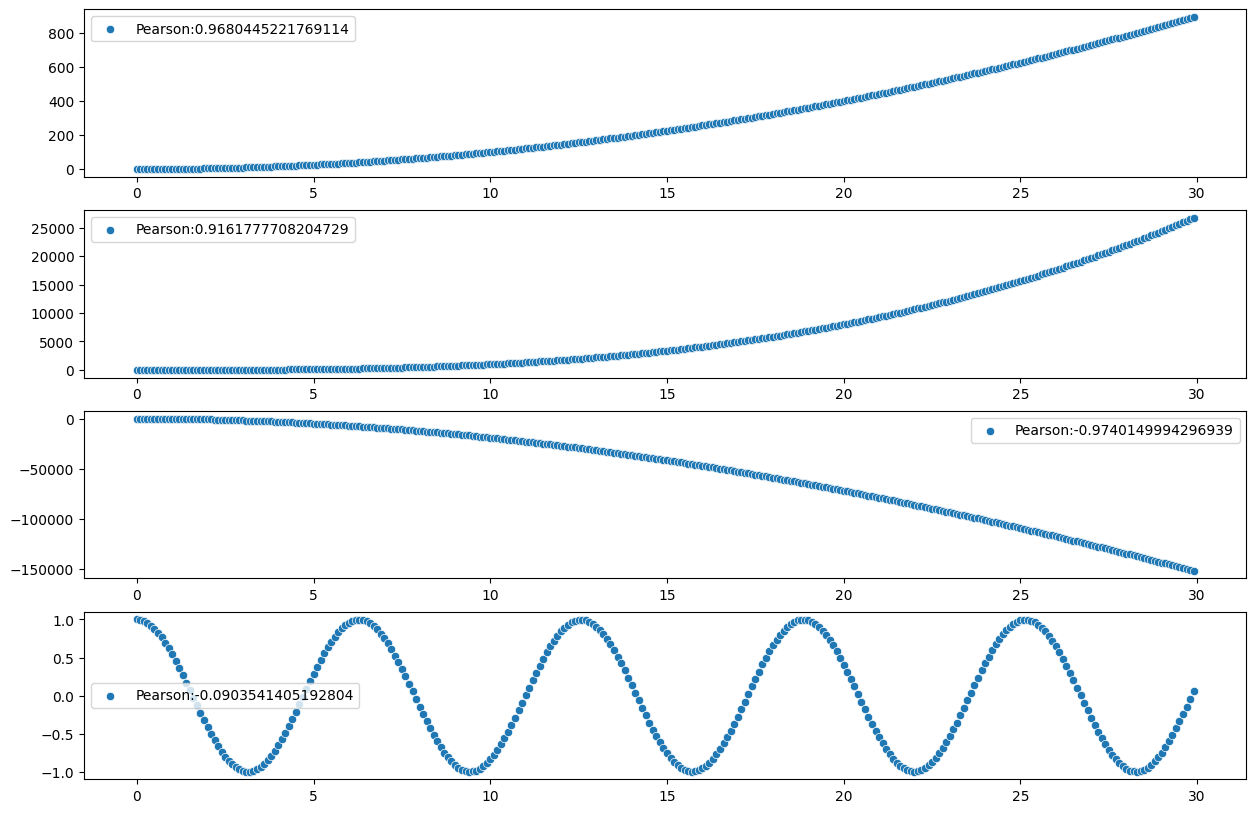

In [110]:
x = np.arange(0, 30, 0.1)

y_list = [lambda x: x**2, lambda x: x**3, lambda x: (x - 200) * x**2, lambda x: np.cos(x)]

y = np.sin(x) + np.random.normal(0, 0.4, size=len(x))
y = np.sin(x) + np.random.normal(0, 0.4, size=len(x))

data = pd.DataFrame({"x": x, "y": y})

fig, ax = plt.subplots(len(y_list), figsize=(15, 10))

for axis, func in zip(ax, y_list):
	y_arr = func(x)
	sns.scatterplot(x=x, y=y_arr, ax=axis)
	data = pd.DataFrame({"x": x, "y": y_arr})
	pearson_correlation = data.corr(method="pearson").iloc[1].values[0]
	xi_obj = Xi(x, y_arr)
	axis.legend([f"Pearson:{pearson_correlation}", f"Xi: {xi_obj.correlation}"])

In [93]:
xi_corr_obj = Xi(data["x"].values, data["y"].values)
correlation = xi_corr_obj.correlation

# Pearson correlation
correlation_pandas = data.corr()


##### RESULT
print(f"Xicorrelation = {correlation}")
print(f"Pandas correlation = {correlation_pandas.iloc[1].values[0]}")

Xicorrelation = 0.5367948532761475
Pandas correlation = -0.10827504006945943
